# Pulsebuilding tutorial part A

## Table of Contents <a class="anchor" id="toc"></a>

 * [Lingo](#lingo)
 * [Blueprints](#blueprints)
   * [Basic blueprinting](#basicbp)
   * [Markers](#markers)
   * [Modifying blueprints](#bp-modify)
   * [Special segments](#specialsegments)
   * [Timesteps](#timesteps)

 * Elements
 * Sequences

## Lingo <a class="anchor" id="lingo"></a>

Let's settle on a vocabulary. At the highest level, we construct **sequences**. These sequences will eventually be uploaded to an AWG, e.g. the Tektronix AWG 5014. Each sequence consists of several **elements** than again consist of a number of **channels**. On each channel reside a **waveform** and two **markers**. The waveform and markers may either be added as numpy arrays or as **blueprint**. A blueprint is a set of instructions for making a waveform and two markers and consists of several **segments**

That is to say, the food chain looks like: segment -> blueprint -> element -> sequence.


### Segments

#### Normal segments

A normal segment consists of a _unique_ name, a function object, a tuple of arguments to the function, an optional number of **timesteps**, and optionally a **duration** bound to it. 

 * The name: can be provided by the user or omitted. If omitted, the segment will get the name of its function. Since all names must be unique, the blueprint _appends numbers_ to names if they occur more than once. The numbers are appended chronologically throughout the blueprint. See example below. Note that valid input (base) names are strings NOT ending in a number. Thus, 'pi/2pulse' is valid, whereas 'pulsepi/2' is not.
 
 * The function: must be a python function taking at least two arguments; the sample rate and the segment duration. If the function takes other arguments (such as ramp slope, frequency, etc.) sample rate and duration arguments must be the last positional arguments. Keyword arguments are currently not allowed. See example at the very end.
 
 * The arguments: are in a tuple of $n-2$ arguments for a function taking $n$ arguments, i.e. specifying everything but the sample rate and duration.
 
 * The number of timesteps: can be 1 (default) or more. This is needed if a segment on one channel is to last while several different segments are run through on another channel of the same element. See example below.

* The durations may be a single value or a tuple of multiple values. The length of said tuple must match the number of timesteps bound to that segment

#### Special segments

A special segment has a (protected) name and a number of arguments. So far, two special segments exist.
 
 * `waituntil`, args [time (int)]:  When put in a blueprint, this function ensures that the _next_ segment starts at the absolute time `time` after the start of the element. It does so by filling any excess time with zeros. It fails if the previous segment will finish after time `time`.
 
 * `makemeanfit`. Not implemented yet. Will make the mean of the blueprint be a specified number. Will (eventually) exist in several versions, e.g. one achieving the goal by adding an offset, another by adding an appropriate DC segment at the end of the blueprint.

### Blueprints

Consist of a number of segments. Has an associated sample rate.

### Elements

Have an associated sample rate. 

### Sequences

Have an associated sample rate. 



In [38]:
#
# IMPORTS
#
%matplotlib nbagg
import pulsebuilding as pb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8, 4.5)

# Blueprints <a class="anchor" id="blueprints"></a> 

## Basic blueprinting <a class="anchor" id="basicbp"></a> 
([back to ToC](#toc))

In this section we show how to construct basic blueprints. The units of the vertical axis is **volts** and the units of the horizontal axis (the durations) is **seconds**.

In [39]:
# The pulsebuilding module comes with a (small) collection of functions appropriate for being segments.
ramp = pb.PulseAtoms.ramp  # args: start, stop
sine = pb.PulseAtoms.sine  # args: freq, ampl, off

# make a blueprint

# The blueprint takes no arguments
bp1 = pb.BluePrint()  # Do-nothing initialisation

# the blueprint is filled via the insertSegment method
# Call signature: position in the blueprint, function, args, name, timesteps, duration(s)
bp1.insertSegment(0, ramp, (0, 1), name='', ts=1, durs=3)

# A sample rate can be set (Sa/S). Without a sample rate, we can not plot the blueprint.
bp1.setSR(100)

# The blueprint can be inspected. Note that the segment was auto-named 'ramp'
bp1.showPrint()

# more segments can be added...
bp1.insertSegment(1, sine, (0.5, 1, 1), name='mysine', ts=1, durs=2)
bp1.insertSegment(2, ramp, (1, 0), name='', ts=1, durs=3)

# ... and reinspected
bp1.showPrint()

Legend: Name, function, arguments, timesteps, durations
Segment 1: "ramp", PulseAtoms.ramp, (0, 1), 1, (3,)
----------
Legend: Name, function, arguments, timesteps, durations
Segment 1: "ramp", PulseAtoms.ramp, (0, 1), 1, (3,)
Segment 2: "mysine", PulseAtoms.sine, (0.5, 1, 1), 1, (2,)
Segment 3: "ramp2", PulseAtoms.ramp, (1, 0), 1, (3,)
----------


<IPython.core.display.Javascript object>


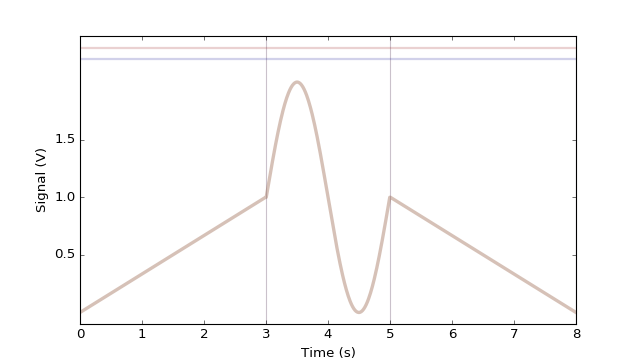

In [40]:
# For easy overview, we may plot the blueprint
bp1.plot()

# The two bleak lines (red, blue) above the graph represent the channel markers.
# They are described below.

<IPython.core.display.Javascript object>


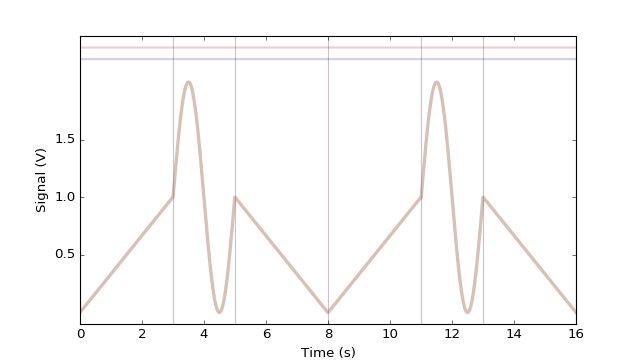

<IPython.core.display.Javascript object>


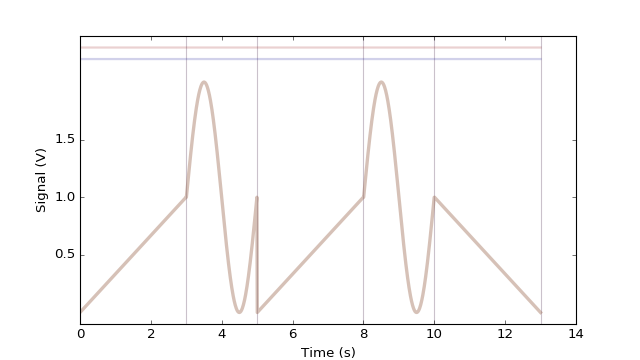

In [41]:
# Blueprints may be added together
bp2 = bp1 + bp1
bp2.plot()

# Segments may be removed from a blueprint. They are removed by name.
bp2.removeSegment('ramp2')
bp2.plot()

In [42]:
# A blueprint has a handful of different lengths one may check
print('Number of points in blueprint: {}'.format(bp1.length_numpoints))
print('Length of blueprint in seconds: {}'.format(bp1.length_seconds))
print('Number of segments in blueprint: {}'.format(bp1.length_segments))
print('Number of timesteps in bluebrint: {}'.format(bp1.length_timesteps))

Number of points in blueprint: 800
Length of blueprint in seconds: 8.0
Number of segments in blueprint: 3
Number of timesteps in bluebrint: 3


## Markers <a class="anchor" id="markers"></a> 
([back to ToC](#toc))

All markers are OFF by default. Markers can be added to a blueprint (switched ON) in two different ways. Either a marker is specified by its ON time in *absolute time* or by its ON time *relative* to a certain segment.

<IPython.core.display.Javascript object>


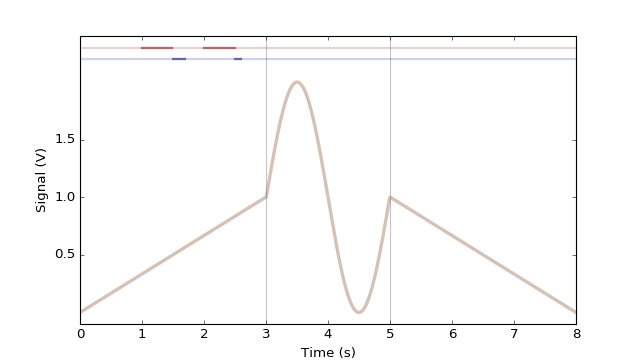

In [43]:
# Absolute time marker specification

# The blueprint has a list of tuples for each marker. The tuples are (switch_on_time, duration)

# create a blueprint
bp_atm = pb.BluePrint()
bp_atm.setSR(100)
bp_atm.insertSegment(0, ramp, (0, 1), durs=3)
bp_atm.insertSegment(1, sine, (0.5, 1, 1), durs=2)
bp_atm.insertSegment(2, ramp, (1, 0), durs=3)

# specify markers in absolute time
bp_atm.marker1 = [(1, 0.5), (2, 0.5)]
bp_atm.marker2 = [(1.5, 0.2), (2.5, 0.1)]

bp_atm.plot()

<IPython.core.display.Javascript object>


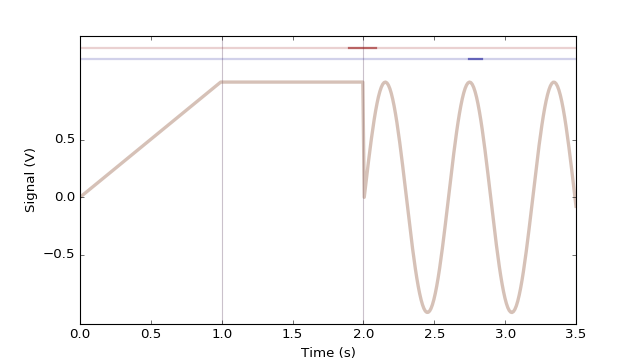

<IPython.core.display.Javascript object>


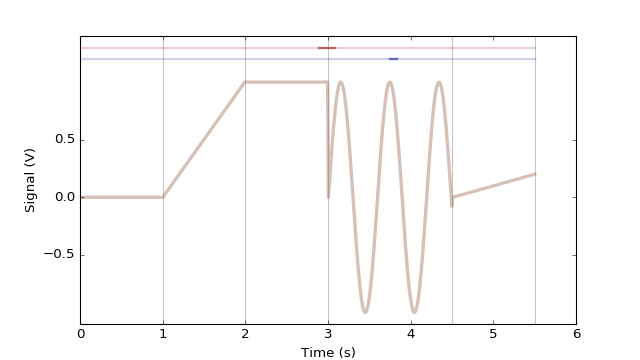

In [44]:
# Relative time marker specification

bp_rtm = pb.BluePrint()
bp_rtm.setSR(100)
bp_rtm.insertSegment(0, ramp, (0, 1), durs=1)
bp_rtm.insertSegment(1, ramp, (1, 1), durs=1)
bp_rtm.insertSegment(2, sine, (1.675, 1, 0), durs=1.5, name='mysine')  # This is the important segment
# make marker 1 go ON a bit before the sine comes on
bp_rtm.setSegmentMarker('mysine', (-0.1, 0.2), 1)  # segment name, (delay, duration), markerID
# make marker 2 go ON halfway through the sine
bp_rtm.setSegmentMarker('mysine', (0.75, 0.1), 2)

bp_rtm.plot()

# Even if we insert segments before and after the sine, the markers "stick" to the sine segment
bp_rtm.insertSegment(0, ramp, (0, 0), durs=1)
bp_rtm.insertSegment(-1, ramp, (0, 0.2), durs=1)

bp_rtm.plot()


# NB: the two different ways of inputting markers will never directly conflict, since one only specifies when to turn 
# markers ON. It is up to the user to ensure that markers switch off again as expected, i.e. that different marker
# specifications do not overlap.

## Modifying blueprints <a class="anchor" id="bp-modify"></a>
([back to ToC](#toc))

<IPython.core.display.Javascript object>


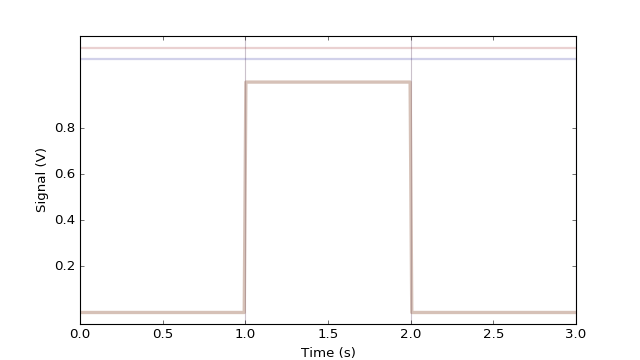

<IPython.core.display.Javascript object>


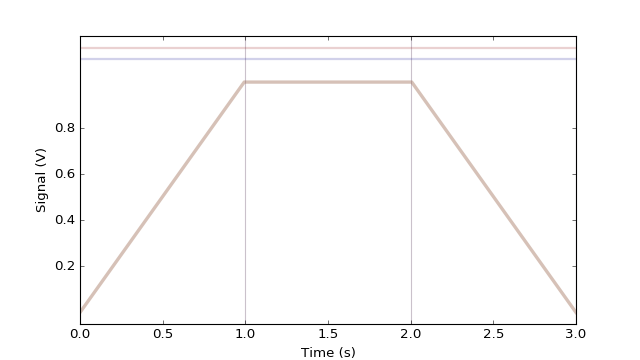

<IPython.core.display.Javascript object>


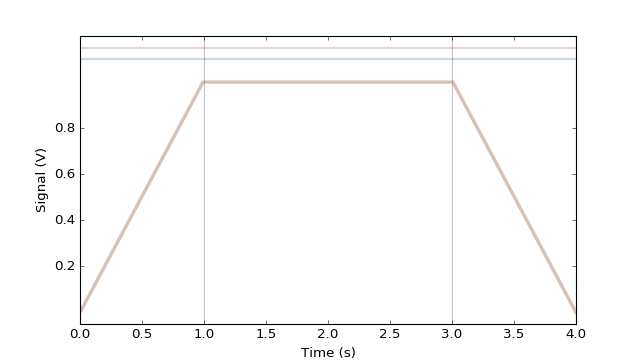

In [60]:
# An essential feature of blueprints is that they can be modified

bp_mod = pb.BluePrint()
bp_mod.setSR(100)

bp_mod.insertSegment(0, ramp, (0, 0), name='before', durs=1)
bp_mod.insertSegment(1, ramp, (1, 1), name='plateau', durs=1)
bp_mod.insertSegment(2, ramp, (0, 0), name='after', durs=1)

bp_mod.plot()

# Functional arguments can be changed

# They are looked up by segment name
bp_mod.changeArg('before', 'stop', 1)  # the argument to change may either be the argument name or its position
bp_mod.changeArg('after', 0, 1)

bp_mod.plot()

# Durations can also be changed
bp_mod.changeDuration('plateau', 2)

bp_mod.plot()

## Special segments <a class="anchor" id="specialsegments"></a>
([back to ToC](#toc))

<IPython.core.display.Javascript object>


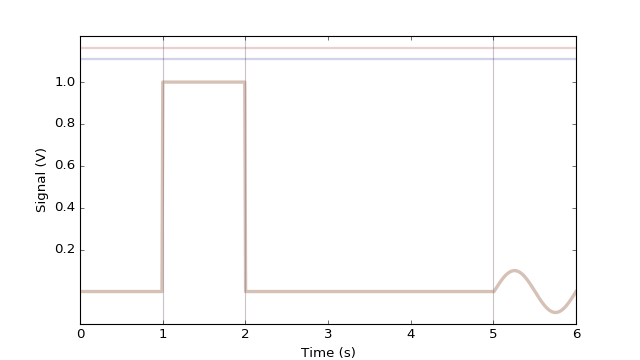

<IPython.core.display.Javascript object>


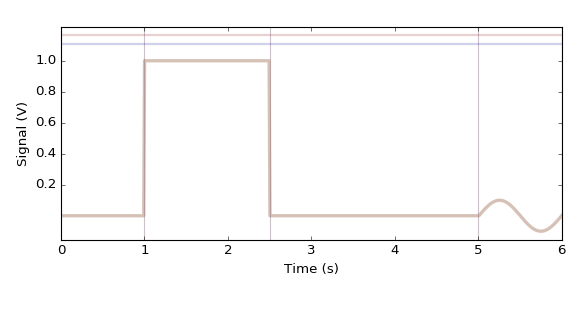

In [64]:
# The 'waituntil' segment fills up a part of the blueprint with zeros

# Example: a square pulse, then waiting until 5 s exactly and then a new sine

bp_wait = pb.BluePrint()
bp_wait.setSR(100)

bp_wait.insertSegment(0, ramp, (0, 0), durs=1)
bp_wait.insertSegment(1, ramp, (1, 1), name='plateau', durs=1)
# function must be sthe string 'waituntil', the argument is the ABSOLUTE time to wait until
bp_wait.insertSegment(2, 'waituntil', (5,))  
bp_wait.insertSegment(3, sine, (1, 0.1, 0), durs=1)
bp_wait.plot()

# If we make the square pulse longer, the sine still occurs at 5 s
bp_wait.changeDuration('plateau', 1.5)
bp_wait.plot()

## Timesteps <a class="anchor" id="timesteps"></a> 
([back to ToC](#toc))

A single segment can last for several timesteps. This is useful when several blueprints are to be "played" simultaneously (see also the [Elements](#elements) section).

<IPython.core.display.Javascript object>


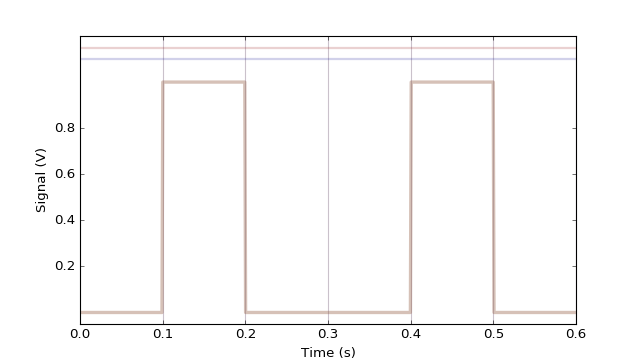

<IPython.core.display.Javascript object>


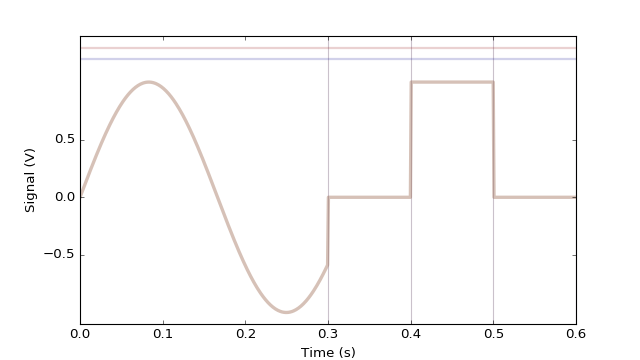

In [70]:
# Example of a sine lasting several timesteps

bp_square = pb.BluePrint()
bp_square.setSR(1000)
bp_square.insertSegment(0, ramp, (0, 0), durs=0.1)
bp_square.insertSegment(1, ramp, (1, 1), durs=0.1)
bp_square.insertSegment(2, ramp, (0, 0), durs=0.1)

bp_boxes = bp_square + bp_square # + bp_square

bp_sine = pb.BluePrint()
bp_sine.setSR(1000)
bp_sine.insertSegment(0, sine, (3, 1, 0), ts=3, durs=(0.1, 0.1, 0.1))

bp_sineandboxes = bp_sine + bp_square # + bp_square

bp_boxes.plot()
bp_sineandboxes.plot()